## This is just me getting my feet wet in ML, classifying the MNIST dataset is a classic start to learning ML so I referenced the following link:

https://towardsdatascience.com/mnist-handwritten-digits-classification-from-scratch-using-python-numpy-b08e401c4dab

In [44]:

import numpy as np
import os
import hashlib
import requests
import gzip
import pandas as pd
import matplotlib.pyplot as plt
import threading as td
import math

In [47]:
path='./'
def fetch(url):
    fp = os.path.join(path, hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(fp):
        with open(fp, "rb") as f:
            data = f.read()
    else:
        with open(fp, "wb") as f:
            data = requests.get(url).content
            f.write(data)
    return np.frombuffer(gzip.decompress(data), dtype=np.uint8).copy()

X = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28*28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]
rand=np.arange(60000)
np.random.shuffle(rand)
train_no=rand[:50000]

val_no=np.setdiff1d(rand,train_no)

X_train,X_val=X[train_no,:,:],X[val_no,:,:]
Y_train,Y_val=Y[train_no],Y[val_no]

In [48]:
X_train.shape

(50000, 28, 28)

# Sigmoid

##### sigmoid function is our activation function, it basically lets us know whether or not something should be activated or not

In [32]:
def sigmoid(x):
    return 1/(np.exp(-x)+1)
def d_sigmoid(x):
    return (np.exp(-x))/((np.exp(-x)+1)**2)

# Softmax

In [49]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0) # only difference

In [50]:
def d_softmax(x):
    exp_element=np.exp(x-x.max())
    return exp_element/np.sum(exp_element,axis=0)*(1-exp_element/np.sum(exp_element,axis=0))

the above can easily be found on stackoverflow forums

# Iterations

In [51]:
def markResultIndex(y):
    #if y=3 we have [0,0,0,1,0,0,0,0,0,0]
    marked = np.zeros((len(y),10)) #makes size 10 array for each y value and marks each index value
    for i in range(len(marked)):
        val = y[i]
        marked[i][val]=1
    return marked

The error is simply the difference in expected yMatrix vs the softmax array

In [52]:
def getError(softArrays, expectedArrays, xL2):
    return 2*(softArrays-expectedArrays)/softArrays.shape[0]*d_softmax(xL2)

In [71]:
def propogate(x,y, l1, l2):
    markedY = markResultIndex(y)
    #SoftMax(Sigmoid(x*W+b))    
    xL1 = x.dot(l1)
    sigOfX = sigmoid(xL1)
    xL2 = sigOfX.dot(l2)
    probabilityArray = softmax(xL2)
    
    err = getError(probabilityArray,markedY, xL2)
    
    newL2 = (sigOfX.T).dot(err)
    
    err = ((l2).dot(err.T)).T*d_sigmoid(xL1)
    newL1 = (x.T).dot(err)
    return probabilityArray, newL1, newL2
    

In [65]:
def getAccuracy(actual, yPred):
    return (actual==yPred).mean()

In [66]:
def mse(actual, yPred):
    diff = actual-yPred
    diffSq = diff**2
    return diffSq.mean()

In [67]:
def sampleRandomDigits(batch):
    randomIndexes = np.random.randint(0,X_train.shape[0],size=batch)
    #above generates 128 random indexes
    x = X_train[randomIndexes]
    x = x.reshape((-1,28*28))
    y = Y_train[randomIndexes]
    return x,y

In [68]:
def sgd(epoch, lr, batch, l1, l2):
    losses = []
    accuracies = []

    for i in range(epoch):
        x,y = sampleRandomDigits(batch)
        out, newL1, newL2 = propogate(x,y, l1, l2)
        
        yPred = np.argmax(out,axis=1)
        loss = mse(yPred,y)
        losses.append(loss)
        
        #use the gradient to modify our NN weights
        l1 = l1-lr*newL1
        l2 = l2-lr*newL2
        
        currAccuracy = getAccuracy(y,yPred)
        accuracies.append(currAccuracy)
        if i%100 == 0:
            print(f"Accuracy: {currAccuracy} Loss:{loss}")
    return losses, accuracies

##### first layer will have 28^2=784 layers since image is 28x28 size last layer has 10 since 0-9

In [69]:

l1=np.random.uniform(-1.,1.,size=(28**2,128))/np.sqrt(128*28**2)
l2=np.random.uniform(-1,1,size=(128,10))/np.sqrt(1280)


In [70]:
epoch = 5000
batch = 128
lr = 0.001

losses,accuracies = sgd(epoch,lr,batch, l1,l2)

Accuracy: 0.03125 Loss:21.828125
Accuracy: 0.1640625 Loss:14.96875
Accuracy: 0.359375 Loss:11.9609375
Accuracy: 0.390625 Loss:11.2578125
Accuracy: 0.4765625 Loss:8.390625
Accuracy: 0.53125 Loss:10.1484375
Accuracy: 0.5390625 Loss:8.4296875
Accuracy: 0.671875 Loss:6.375
Accuracy: 0.609375 Loss:6.3203125
Accuracy: 0.5703125 Loss:7.6484375
Accuracy: 0.6015625 Loss:7.7421875
Accuracy: 0.6171875 Loss:7.28125
Accuracy: 0.71875 Loss:5.9453125
Accuracy: 0.59375 Loss:6.640625
Accuracy: 0.703125 Loss:5.625
Accuracy: 0.6796875 Loss:6.7890625
Accuracy: 0.71875 Loss:5.2265625
Accuracy: 0.703125 Loss:4.78125
Accuracy: 0.765625 Loss:4.5390625
Accuracy: 0.71875 Loss:5.296875
Accuracy: 0.7109375 Loss:4.2109375
Accuracy: 0.6796875 Loss:6.578125
Accuracy: 0.6484375 Loss:7.15625
Accuracy: 0.7421875 Loss:4.015625
Accuracy: 0.7109375 Loss:4.5859375
Accuracy: 0.6796875 Loss:5.75
Accuracy: 0.7578125 Loss:5.171875
Accuracy: 0.7109375 Loss:5.40625
Accuracy: 0.7578125 Loss:5.0703125
Accuracy: 0.640625 Loss:9.203

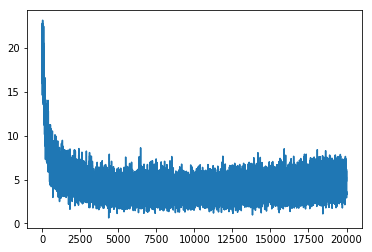

In [62]:
plt.plot(losses)

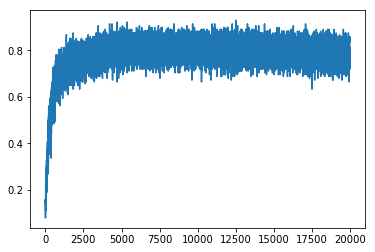

In [63]:
plt.plot(accuracies)

We observe that our losses fall closer to 0, which means that we are learning something. 